#Three Hundred and Forty-Nine Cameras

## Clustering features to find the people behind the cameras
Can we go from the 349 cameras with serial numbers (`camera_serial_number`) to find additional salient features?
Can we cluster users based on camera metadata?

(At this point, the notion that the serials are perfect is pretty demonstrably false. We should consider drawing a slice based on some other features.)

### Setup

In [1]:
from itertools import combinations
from itertools import product
import ujson as json
import matplotlib as mpl
import matplotlib.pyplot as plot
import numpy as np
import os
import pandas as pd
import pickle
import seaborn as sns

%matplotlib inline
sns.set(context='talk', font='monospace', style='darkgrid')

In [2]:
def image_cleaner(img):
    """
    clean up image metadata JSON extracted by Tika.
    :param dict img: dictionary of JSON features
    :returns dict: modified JSON features
    """
    to_del = ['meta']
    for key in img:
        if isinstance(img[key], list):
            if len(img[key]) == 1:
                img[key] = img[key][0]
                # Kill empty lists and empty strings
                # We are _assuming_ that list entries are strings
            if len(img[key]) == 0:
                to_del.append(key)
            
    for key in to_del:
        del img[key]
    
    if 'content' in img:
        img['content'] = ' '.join(img['content'].strip().split())
    else:
        img['content'] = ''
    
    if 'f_number' in img:
        if isinstance(img['f_number'], list):
            img['f_number'] = [x for x in img['f_number'] if x[0].lower() == 'f'][0]
        if isinstance(img['f_number'], str):
            try:
                img['f_number'] = float(img['f_number'][1:].strip())
            except:
                print(img['f_number'])
    
    if 'id' in img:
        img['id'] = img['id'].replace('/data/roxyimages/', '').replace('.jpg', '')
    
    # meta-feature for describing all listed features
    img['features'] = frozenset([key for key in img.keys()])
    
    if 'camera_serial_number' in img:
        img['camera_serial_number'] = ''.join(x for x in img['camera_serial_number'] if x.isdigit())
    if 'x_parsed_by' in img:
        img['x_parsed_by'] = str(set(img['x_parsed_by']))[1:-1]
    if 'artist' not in img:
        img['artist'] = ''
    if isinstance(img['color_space'], list):
        img['color_space'] = str(set(img['color_space']))[1:-1]
        
    return img

`serials.json` contains JSON for all cameras that have a serial number field, pulled from [JPL's](http://www.jpl.nasa.gov/) [ImageCat](https://github.com/chrismattmann/imagecat) [Solr](http://lucene.apache.org/solr/) endpoint. ([Facet View of ImageCat](http://memex.dyndns.org:8081/facetview/), [Graphs of ImageCat](http://memex.dyndns.org:8081/banana/#/dashboard)) This is *far* too small of a sample to be considered representative of the RoxyImages data. ([Chris Mattmann](https://memexproxy.com/wiki/display/~cmattmann) is JPL's lead on this.)

In [3]:
jsn = json.load(open('../serial_numbers/serials.json'))
imgs = [image_cleaner(x) for x in jsn['response']['docs']]

no_serial = [img for img in imgs if 'camera_serial_number' not in img]
imgs = [img for img in imgs if 'camera_serial_number' in img]
    
serials = {img['camera_serial_number'] for img in imgs}
models = {img['model'] for img in imgs}
print('There are {} images attributed to {} camera serial numbers,'.format(
        len(imgs), len(serials)))
print('... and to {} camera models.'.format(
        len(models)))

There are 974 images attributed to 349 camera serial numbers,
... and to 49 camera models.


In [4]:
# Aggressively prune the data frame by killing all unique fields and all fields with constant values
img_df = pd.DataFrame.from_records(imgs)
img_df.set_index('id', inplace=True)
print(img_df.shape)
img_df_2 = img_df.dropna(1)
print(img_df_2.shape)
img_df_2 = img_df_2.ix[:, img_df_2.apply(lambda x: x.value_counts().shape[0] != 1 , 0)]
print(img_df_2.shape)

(974, 591)
(974, 44)
(974, 40)


### What can we say about the metadata that define...
#### ...a camera's model?

In [5]:
img_df_2['model'].value_counts().head()

NIKON D5000    107
NIKON D90       62
NIKON D7000     61
NIKON D80       61
NIKON D5100     56
dtype: int64

In [6]:
img_df_2.groupby('model').agg(
    lambda x: x.apply(
        lambda y: y.value_counts().shape[0] == 1, 0)).T.apply(
    lambda z: z.value_counts(), 0).T.fillna(0).head()

,False,True
model,,
Canon EOS 10D,31,8
Canon EOS 20D,33,6
Canon EOS 300D DIGITAL,0,39
Canon EOS 30D,31,8
Canon EOS 350D DIGITAL,0,39


#### ...a particular artist?

In [7]:
img_df_2['artist'].value_counts().head()

                 850
Picasa            70
JamesJennings     10
Shaiquann          7
Walt Kiefer        5
dtype: int64

In [8]:
img_df_2.groupby('artist').agg(
    lambda x: x.apply(
        lambda y: y.value_counts().shape[0] == 1, 0)).T.apply(
    lambda z: z.value_counts(), 0).T.fillna(0).head()

,False,True
artist,,
,39,0
Alex Georgevitch,0,39
Arne Fleischmann,0,39
Bruno Talledo,19,20
CHARLES D. HOWELL,7,32


#### ...a particular serial number?

In [9]:
img_df_2['camera_serial_number'].value_counts().head()

3307656     30
3151403     29
0000000     25
3447774     22
00000175    21
dtype: int64

In [10]:
img_df_2.groupby('camera_serial_number').agg(
    lambda x: x.apply(
        lambda y: y.value_counts().shape[0] == 1, 0)).T.apply(
    lambda z: z.value_counts(), 0).T.fillna(0).head()

,False,True
camera_serial_number,,
0000000,22,17
00000039,0,39
0000005,0,39
00000079,0,39
00000110,0,39


## Importing metadata similarity data
### Import and setup
`metadata_jaccard_df` (defined in `Image Metadata Clustering.ipynb`) is a DataFrame containing jaccard similarities between the different images listed in `serials.json`. It has three key colums:
* `set`: The similarity of the different metadata feature *labels*
* `value`: The similarity of the different feature *content* (of matching labels)
* `hmean`: The [harmonic mean](http://mathworld.wolfram.com/HarmonicMean.html) of these two values.

In [11]:
metadata_jaccard_df = pickle.load(open('metadata_jaccard_df.pkl', 'rb'))

### Simple graphs

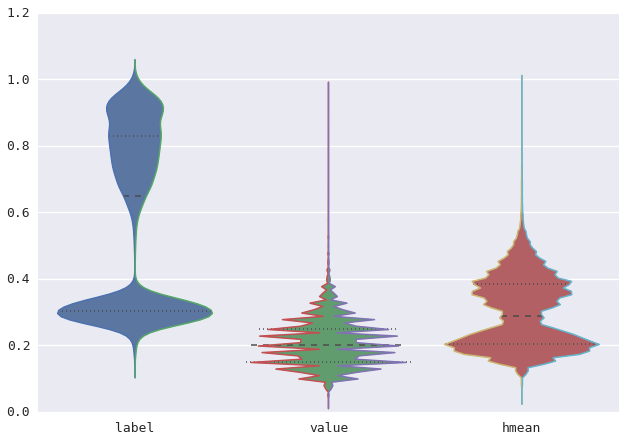

In [12]:
sns.violinplot(metadata_jaccard_df.ix[:, ['label', 'value', 'hmean']])

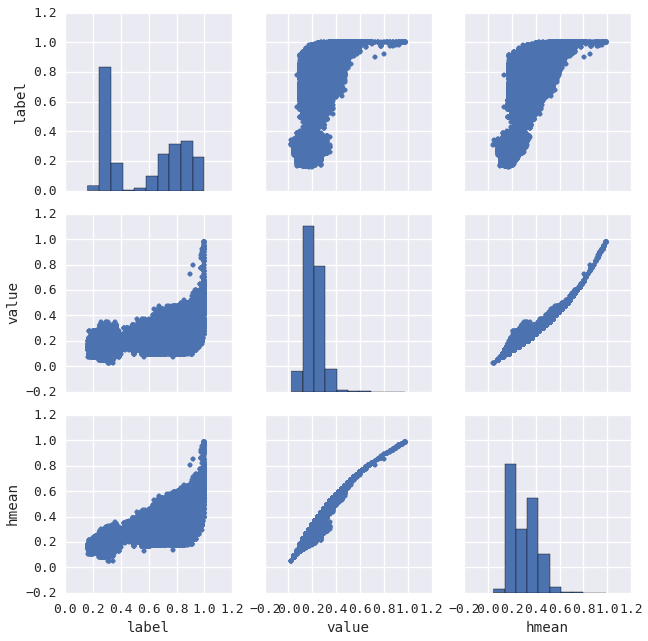

In [13]:
sns.pairplot(metadata_jaccard_df.ix[:, ['label', 'value', 'hmean']])

The correlation of `hmean` and `value` is interesting.

`label` and `value` have an obvious relationship: as the intersection of feature labels increases, so too does the range of possible value intersection sizes. The `hmean` correlation might be tied to this increasing expressiveness.

The quadratic fit, below, *looks* pretty good, but seems like it might have some systematic problems. It's also, of course, kind of moot, since it's not like calculating harmonic mean is a real issue.

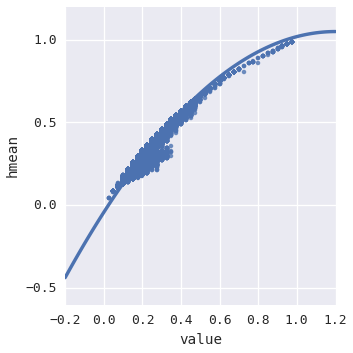

In [14]:
sns.lmplot('value', 'hmean', metadata_jaccard_df, order=2);

In [15]:
metadata_jaccard_df.ix[:, ['label', 'value', 'hmean']].describe()

,label,value,hmean
count,473851.000000,473851.000000,473851.000000
mean,0.574003,0.207940,0.298787
std,0.266001,0.071641,0.108215
min,0.160714,0.025000,0.046232
25%,0.302158,0.150000,0.203125
50%,0.649425,0.200000,0.288435
75%,0.828025,0.250000,0.384146
max,1.000000,0.975000,0.987342


## Importing ad text similarity data
Many images show up in many ads; as such, bringing the two kinds of data together can cause a blow-up in the number of rows.

The ad text data comes from the [elasticsearch](https://www.elastic.co/products/elasticsearch) interface to [ISI's](http://www.isi.edu/home) ad data. They already have extracted and calculated the jaccard similarities of a *vast* number of ad texts. Because of some interface issues, I've re-calculated these similarities. (See `Advertisement Text Clustering.ipynb`) Since tokenization, stopword deletion, and other choices can impact similarities, my jaccard values may differ from those returned by ISI. ([Dipsy Kapoor](https://memexproxy.com/wiki/display/~dkapoor), under [Pedro Szekely](https://memexproxy.com/wiki/display/~pszekely), is ISI's lead on this.)

### Import and setup
`cluster_jaccard_df` (defined in `Advertisement Text Clustering.ipynb`) contains the jaccard similarities between different clusters of ad texts. A "cluster" is the hexidecimal digest of the SHA1 hash of an ad's text; many ad texts are repeated in different ads, and this is a first pass on clustering the data. That said, some ads have *exactly* the same text but re-cut in different orders. This *isn't* caught by the hash, so you will have different clusters with a 1.0 similarity to each other. Fixing this shouldn't be a big deal, since we'll hopefully be moving to ISI's clusters.

`body_cluster_image_ad_df` (defined in `Advertisement Text Clustering.ipynb`) is a mapping dataframe, intended to provide a key for going from an ad's text, to its cluster, to its image, and to its unique ad id. The text-cluster mapping is redundant, since cluster can be derived from text.)

In [16]:
cluster_jaccard_df = pickle.load(open('cluster_jaccard_df.pkl', 'rb'))
body_cluster_image_ad_df = pickle.load(open('body_cluster_img_ad_df.pkl', 'rb'))

### Simple graphs

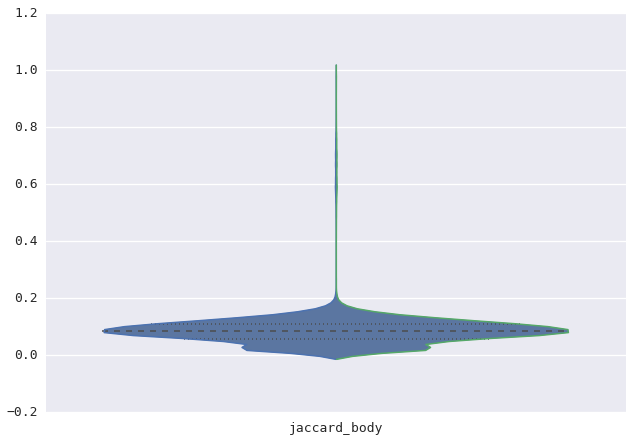

In [17]:
sns.violinplot(cluster_jaccard_df)

In [18]:
cluster_jaccard_df['jaccard_body'].describe()

count    263901.000000
mean          0.085624
std           0.065694
min           0.000000
25%           0.056604
50%           0.082437
75%           0.106870
max           1.000000
Name: jaccard_body, dtype: float64

## Importing image similarity data
The image similarity data comes from the Web Interface. for ISI's image similarity tool; all similarities have been calculated using [Columbia's](http://www.columbia.edu) [Sentibank](http://www.ee.columbia.edu/ln/dvmm/vso/download/sentibank.html) methods, possibly with additional stuff on top. [Tao Chen](https://memexproxy.com/wiki/display/~tchen), under [Pedro Szekely](https://memexproxy.com/wiki/display/~pszekely), is the lead on this.

During my test, I found that the HTTP interface is *waaaay* slower than elasticsearch database from which I pulled other ISI data. If there's any way we can access the similarity data using elasticsearch or some other, faster protocol, it'd be great.

The API is queried by image, as opposed to image pair, and returns a list of the top *N* images and their similarity values. (I'm unclear what determines *N* for a particular query.) *Many* of the images in the metadata pool don't show up in the ranked list of *N* individuals. As such, despite being a very large list of pairs, almost all of them are dropped when combined with the metadata. This is very convenient for right now, but a problem for the longer term. It'd be *great* if we could query the API with particular lists of pairs and get back a list of similarities. Alternately, since we can query solr quite fast, we could draw lists of visually similar ad images and then rapidly pull down their metadata features.

### Import and setup
`image_similarity_df` (defined in `Extract Image Similarity Values.ipynb`) contains all of sentibank similarity values for different pairs of images.


In [19]:
image_similarity_df = pickle.load(open('image_similarity_df.pkl', 'rb'))
image_similarity_df.set_index('ad_img_pairs', inplace=True)

### Simple graphs

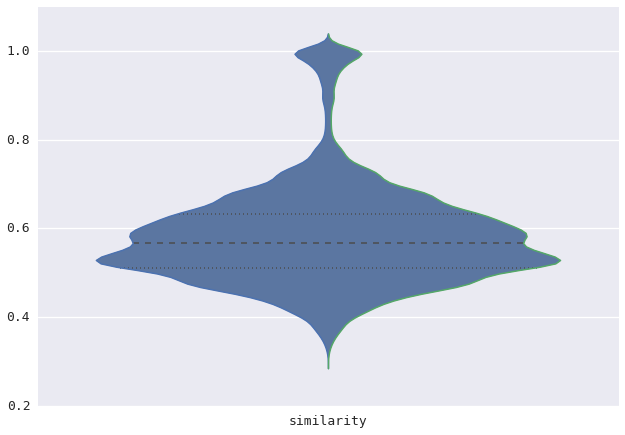

In [20]:
sns.violinplot(image_similarity_df['similarity'], names=['similarity'])

## Combine image metadata and visual similarities.

We're going to ignore ads right now, because going from images to ads (and vice versa) is a big can of worms. Let's look at image similarity pairs.

In [21]:
metadata_id_one = set(list(x)[0] for x in metadata_jaccard_df.index)
metadata_id_two = set(list(x)[1] for x in metadata_jaccard_df.index)
similarity_id_one = set(list(x)[0] for x in image_similarity_df.index)
similarity_id_two = set(list(x)[1] for x in image_similarity_df.index)

all_metadata_imgs = metadata_id_one | metadata_id_two
all_similarity_imgs = similarity_id_one | similarity_id_two

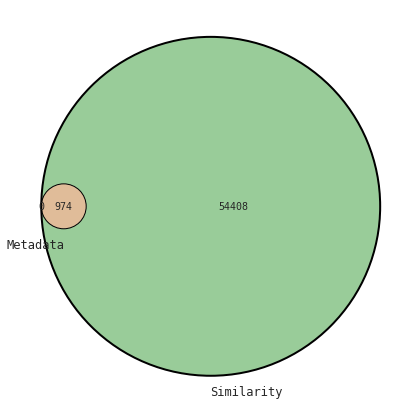

In [22]:
# Image similarity data completely subsume the metadata data
from matplotlib_venn import venn2, venn2_circles
only_metadata = len(all_metadata_imgs - all_similarity_imgs)
only_similarity = len(all_similarity_imgs - all_metadata_imgs)
both = len(all_metadata_imgs & all_similarity_imgs)


venn2(subsets = (only_metadata, only_similarity, both),
      set_labels= ('Metadata', 'Similarity', 'Both'))
c = venn2_circles(subsets = (len(all_metadata_imgs - all_similarity_imgs),
                             len(all_similarity_imgs - all_metadata_imgs),
                             len(all_metadata_imgs & all_similarity_imgs)),
                  linestyle='solid')
c[0].set_lw(1.0)

In [23]:
# Almost no similarities. VERY unclear why grouping our small set of similarity values
# includes duplicate index values, but it does.
meta_similarity_df = pd.merge(metadata_jaccard_df,
                              image_similarity_df,
                              left_index=True,
                              right_index=True)
print(meta_similarity_df.shape)
merged_slice_df = meta_similarity_df.groupby(level=0).agg(max)
len(set(merged_slice_df.index))

(247, 8)


169

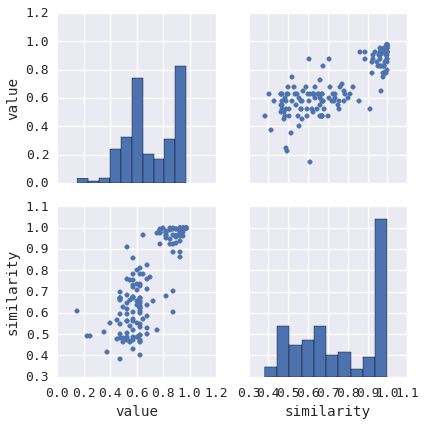

In [24]:
sns.pairplot(merged_slice_df.ix[:, ['value', 'similarity']])

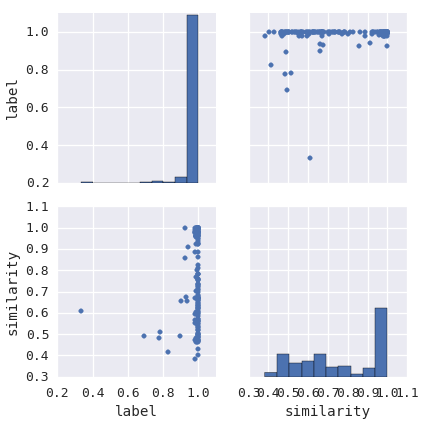

In [25]:
sns.pairplot(merged_slice_df.ix[:, ['label', 'similarity']])

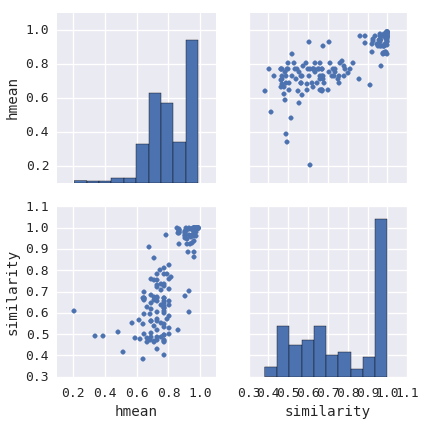

In [26]:
sns.pairplot(merged_slice_df.ix[:, ['hmean', 'similarity']])

### Combine image data with ad text data.

Let's open the can of worms mentioned abiove. We want to take the similarities of the ad texts and determine...
* The "internal" ad text (jaccard) similarity of an image: How similar are the texts of the ads with which it is associated to each other
* The "external" ad text (jaccard) similarity of two images: What is the average similarity of *all* of the ads seen used by these two images.

#### Setup
To setup, we draw a list of all of the images that have had comparable similarity and metadata values.

In [27]:
all_pairs = list(merged_slice_df.index)
img_set = set()
for x in all_pairs:
    y = list(x)
    img_set.add(y[0])
    img_set.add(y[1])

#### Internal ad text (jaccard) similarity

In [28]:
bcia_slice = body_cluster_image_ad_df.ix[
    body_cluster_image_ad_df['id'].apply(lambda x: x in img_set),
    :]
print(bcia_slice.shape)
print(bcia_slice['id'].nunique())

(1045, 4)
270


In [29]:
internal_sim = {'id': [], 'internal_text_jaccard': []}
for img, groups in bcia_slice.groupby('id'):
    all_clusters = set(groups['cluster'])
    if len(all_clusters) == 1:
        continue
    cluster_pairs = [frozenset(x) for x in combinations(all_clusters, 2)]
    internal_sim['id'].append(img)
    internal_sim['internal_text_jaccard'].append(
        np.mean(cluster_jaccard_df.ix[cluster_pairs].values))

internal_text_sim_df = pd.DataFrame(internal_sim).set_index('id')

In [30]:
internal_text_sim_df.describe()

,internal_text_jaccard
count,107.000000
mean,0.605091
std,0.303644
min,0.077922
25%,0.331794
50%,0.664877
75%,0.857920
max,0.982143


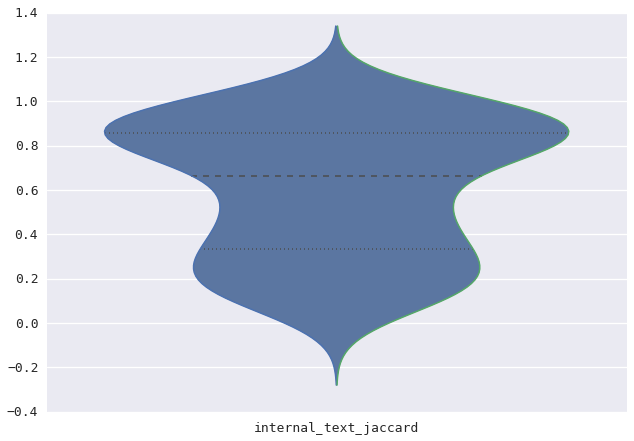

In [31]:
sns.violinplot(internal_text_sim_df)

#### External ad text (jaccard) similarity

Thanks to having run this code a few dozen times, I know that image `df9bca22d5f1faa7ca715bf6dbbca2f6c5668a14` is missing from the ad body data set; the elasticsearch turned up no ad body texts associated with that image. This is a good indicator of the disconnect between the two data sets. We should verify with Pedro, Tao, Dipsy, and Chris that the JPL and ISI roxy images data sets are aligned.

In [32]:
from itertools import product
external_sim = {'ad_img_pair': [], 'external_text_jaccard': []}
for pair in all_pairs:
    first_clusters = set(bcia_slice.ix[bcia_slice['id'] == list(pair)[0], 'cluster'])
    second_clusters = set(bcia_slice.ix[bcia_slice['id'] == list(pair)[1], 'cluster'])
    if len(first_clusters) == 0 or len(second_clusters) == 0:
        print('Something\'s missing: {}'.format(pair))
        continue
    
    external_sim['ad_img_pair'].append(pair)
    
    if first_clusters == second_clusters:
        # If these guys are all used in the same ad clusters, they should be considered 
        # identical.
        # Is that right? Arguably, they should be considered as similar
        # as their internal similarity.
        external_sim['external_text_jaccard'].append(1.)
        continue
    cluster_pairs = [frozenset(x) for x in product(first_clusters, second_clusters)]
    external_sim['external_text_jaccard'].append(
        np.mean(cluster_jaccard_df.ix[cluster_pairs].dropna().values))
    
external_text_sim_df = pd.DataFrame(external_sim).set_index('ad_img_pair')

Something's missing: frozenset({'df9bca22d5f1faa7ca715bf6dbbca2f6c5668a14', '419612838a0206fcdf19adb79040432f509e76ee'})
Something's missing: frozenset({'df9bca22d5f1faa7ca715bf6dbbca2f6c5668a14', '38c5b51f80facac3d52200fdd89a64fcd89558cb'})
Something's missing: frozenset({'df9bca22d5f1faa7ca715bf6dbbca2f6c5668a14', '2ae0aa22dbc8ecddb4625f83d7148a5edb97e9c6'})
Something's missing: frozenset({'df9bca22d5f1faa7ca715bf6dbbca2f6c5668a14', '5d5f9929505aeaea4422c9f071d3d04c2f181891'})
Something's missing: frozenset({'df9bca22d5f1faa7ca715bf6dbbca2f6c5668a14', 'd739adbb52f83b69565ddf810f7d2e60c04c3996'})


In [33]:
external_text_sim_df.describe()

,external_text_jaccard
count,164.000000
mean,0.540408
std,0.416912
min,0.000000
25%,0.117657
50%,0.412872
75%,1.000000
max,1.000000


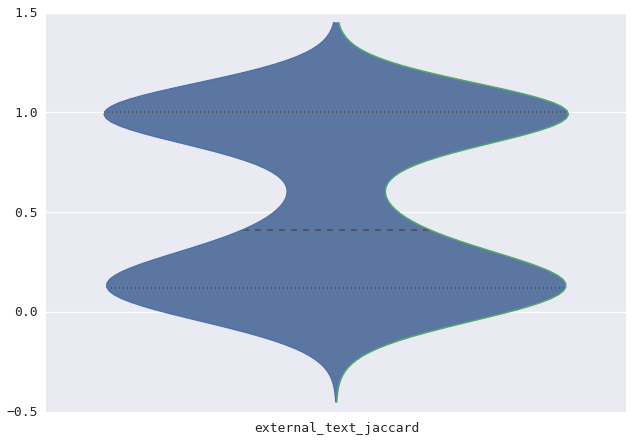

In [34]:
sns.violinplot(external_text_sim_df)

In [35]:
external_merged_slice_df = merged_slice_df.join(external_text_sim_df).dropna()

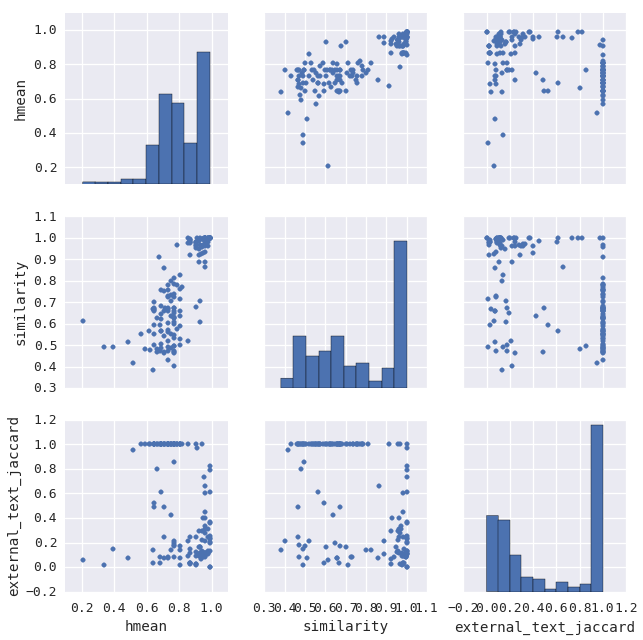

In [36]:
sns.pairplot(external_merged_slice_df.ix[:, ['hmean', 'similarity', 'external_text_jaccard']])

**349 Cameras took 974 pictures.**

**They were used in 1,683 ads with 727 body texts,**

**along with 12,266 *other* pictures**